# MCLP Simulation

### Below we will simulate tokenomics startegies for a Multi-Company-Loyalty-Program

In [7]:
# Import packages

import random
import matplotlib.pyplot as plt
import numpy as np
import random


In [1]:
# To DOS:

# Integrate quarterly voting mechanism -- done
# Update growth rate -- done

In [6]:
# Incentive Curves

# Define function for s-shaped incentive curve
def incentive_curve_sigmoid(x, max_value, midpoint):
    # Curve starts at 1 when x is 0
    base_adjustment = 1 - (max_value / (1 + np.exp(0.1 * midpoint)))
    return max_value / (1 + np.exp(-0.1 * (x - midpoint))) + base_adjustment


def incentive_curve_linear(x, max_value, slope):
    # Linear function starting at 1 when x is 0
    return max(min(slope * x + 1, max_value), 1)

def incentive_curve_root(x, max_value, midpoint):
    # Adjust the curve to start at 1
    base_adjustment = 1 - (max_value * np.sqrt(1 - midpoint) / np.sqrt(max_value + 1))
    return max(max_value * np.sqrt((x - midpoint) + 1) / np.sqrt(max_value + 1) + base_adjustment, 1)


## Partner Company Data

In [62]:
# Define partner data
partners = {
    "Partner 1": {"Sales Events": 8245, "Average Basket Value": 121.29, "Industry": 1},
    "Partner 2": {"Sales Events": 1002, "Average Basket Value": 49.90, "Industry": 2},
    "Partner 3": {"Sales Events": 19003, "Average Basket Value": 31.57, "Industry": 2},
    "Partner 4": {"Sales Events": 436, "Average Basket Value": 30257.19, "Industry": 3},
}

# Account for competition effects

def calculate_competition_effect(partners, industry_competition_factor):
    industry_counts = {}
    competition_effects = {}

    # Count the number of partners in each industry
    for partner, data in partners.items():
        industry = data["Industry"]
        industry_counts[industry] = industry_counts.get(industry, 0) + 1

    # Calculate competition effect for each partner
    for partner, data in partners.items():
        industry = data["Industry"]
        # The more competitors, the stronger the negative effect
        competition_effect = 1 - (industry_counts[industry] - 1) * industry_competition_factor
        competition_effect = max(competition_effect, 0)  # Ensure it doesn't go negative
        competition_effects[partner] = competition_effect

    return competition_effects


industry_competition_factor = 0.05  # Example value
competition_effects = calculate_competition_effect(partners, industry_competition_factor)

# Adjust partner data based on competition effects
for partner in partners:
    competition_effect = competition_effects[partner]
    partners[partner]["Adjusted Sales Events"] = partners[partner]["Sales Events"] * competition_effect


## Gamification


In [9]:
# To incentivize customers to transition to higher tiers, higher tiers have higher earning rates
# For example in Tier 3 0.15 Tokens are earned per dollar spent
tier_rates = {
    "Tier 1": 0.05,
    "Tier 2": 0.1,
    "Tier 3": 0.15
}

# Customers can slide into a higher tier by surpassing the accumulated spending thresholds
tier_thresholds = {
    "Tier 2": 500,
    "Tier 3": 1000
}

# Tier Maintenance is a gamification-mechanism that incentivizes customers to increase spending, as they may risk sliding down after one month
# The thresholds refer to monthly spending levels within the partner network that need to be exceeded in order to remain in the tier
tier_maintenance = {
    "Tier 2": 250,
    "Tier 3": 500
}

total_tokens_redeemed = {}

# Model 1: Tiered


In [72]:
class CustomerT:

    id_counter = 0  # Static counter for unique IDs
    BASE_SPEND_PROBABILITY = 0.5  # 50% chance to spend without any incentives

    def __init__(self):
        self.tier = "Tier 1"   # Initialize each customer as Tier 1
        self.total_spent = 0   # Token spent = 0
        self.tokens = 0        # Token held = 0
        self.current_month_spent = 0      # Token spent current month = 0
        self.savings = 0   # cumulative savings
        self.id = CustomerT.id_counter
        CustomerT.id_counter += 1

    TOKEN_VALUE = 0.5  # e.g., each token is worth 0.5€

    TIER_SPEND_VALUES = {
        "Tier 1": 0,   # Base x-value for Tier 1
        "Tier 2": 1,   # Base x-value for Tier 2
        "Tier 3": 2    # Base x-value for Tier 3
    }


    def incentive_to_spend(self):
        # Base x-value from tier
        base_x_value = self.TIER_SPEND_VALUES[self.tier]

        # Adding token-based component to x-value
        token_component = 0.01 * self.tokens

        # Introducing randomness using normal distribution
        random_component = np.random.normal(0, 0.2)

        # Total x-value for incentive curve with randomness
        x_value = base_x_value + token_component + random_component

        # Using your chosen incentive curve function with the calculated x-value
        # Replace with prefered incentive curve function and parameters
        multiplier = incentive_curve_linear(x_value, slope=0.5, max_value=2.0)

        # Calculating incentive probability
        incentive_prob = self.BASE_SPEND_PROBABILITY * multiplier

        # Ensure the probability does not exceed 1
        return min(incentive_prob, 1)

    def spend(self, partners):
        # Use Adjusted Sales Events for partner probabilities
        partner_probabilities = [data.get("Adjusted Sales Events", data["Sales Events"]) / 12 for _, data in partners.items()]
        total_events = sum(partner_probabilities)
        partner_probabilities = [p / total_events for p in partner_probabilities]
        
        should_spend = random.random() < self.incentive_to_spend()
        if should_spend:
            partner = random.choices(list(partners.keys()), weights=partner_probabilities, k=1)[0]
            spend_value = random.uniform(0, partners[partner]["Average Basket Value"] * 2)
            self.total_spent += spend_value
            return partner, spend_value
        return None, 0

    def earn_tokens(self, spend_value):
        earn_rate = tier_rates[self.tier]
        self.tokens += spend_value * earn_rate

    def update_tier(self):
        new_tier = self.tier  # Start by assuming current tier

        if self.total_spent >= tier_thresholds["Tier 3"]:
            new_tier = "Tier 3"
        elif self.total_spent >= tier_thresholds["Tier 2"]:
            new_tier = "Tier 2"
        else:
            new_tier = "Tier 1"

        # Maintenance
        if new_tier == "Tier 3" and self.current_month_spent < tier_maintenance["Tier 3"]:
            new_tier = "Tier 2"
        if new_tier == "Tier 2" and self.current_month_spent < tier_maintenance["Tier 2"]:
            new_tier = "Tier 1"

        self.tier = new_tier
        self.current_month_spent = 0

    def redeem_tokens(self, mean_rate=0.20, std_dev=0.2):
        # Sample from a normal distribution with the given mean and standard deviation
        sampled_rate = np.random.normal(mean_rate, std_dev)
        
        # Ensure the rate is within the range [0, 1]
        sampled_rate = max(0, min(1, sampled_rate))
        
        redeemed_tokens = self.tokens * sampled_rate
        redeemed_value = redeemed_tokens * self.TOKEN_VALUE  # Calculate the monetary value of redeemed tokens

        self.tokens -= redeemed_tokens
        
        # Return both redeemed tokens and the monetary savings from redemption
        return redeemed_tokens, redeemed_value
    
    def calculate_competition_effect(partners, industry_competition_factor):
        industry_counts = {}
        competition_effects = {}

        # Count the number of partners in each industry
        for partner, data in partners.items():
            industry = data["Industry"]
            industry_counts[industry] = industry_counts.get(industry, 0) + 1

        # Calculate competition effect for each partner
        for partner, data in partners.items():
            industry = data["Industry"]
            # The more competitors, the stronger the negative effect
            competition_effect = 1 - (industry_counts[industry] - 1) * industry_competition_factor
            competition_effect = max(competition_effect, 0)  # Ensure it doesn't go negative
            competition_effects[partner] = competition_effect

        return competition_effects
    
    @staticmethod
    def generate_new_partner_data():
        # Simulate the generation of new partner data
        simulated_sales = random.randint(1000, 100000)  # Random sales between 1,000 and 100,000
        average_basket_value = random.randint(5, 500)   # Random average basket value between 5 and 500

        # Example: Using a power function to reduce the frequency of hitting the ceiling
        # Calculate the size factor based on sales and average basket value with more variability
        # Introduce a power function and a randomness factor
        randomness_factor = random.uniform(0.01, 0.1)  # Random factor 
        size_factor = (((simulated_sales / 100000) ** 0.5 + (average_basket_value / 500) ** 0.5) / 2) * randomness_factor


        # Ensuring the size factor doesn't exceed the maximum limit of 40%
        max_size_factor = 0.2
        size_factor = min(size_factor, max_size_factor)

        return {
                "Sales Events": simulated_sales,
                "Average Basket Value": average_basket_value,
                "Industry": random.randint(1, 5),
                "Conversion Rate to Central": random.uniform(0.4, 1),
                "size_factor": size_factor  
            }

    def conduct_vote(existing_partners, new_partner_applications):
        accepted_partners = []

        for new_partner_data in new_partner_applications:
            # Counting the number of yes votes
            yes_votes = 0
            total_votes = len(existing_partners) + 1  # Including the third party

            # Votes from existing partners
            for _ in existing_partners:
                vote = random.choice([True, False])  # Random vote for each partner
                if vote:
                    yes_votes += 1

            # Third-party vote
            third_party_vote = random.choice([True, False])
            if third_party_vote:
                yes_votes += 1

            # Determine if the new partner is accepted
            if yes_votes > total_votes / 2:
                    accepted_partners.append(new_partner_data)

        return accepted_partners    
    
    def calculate_customer_growth(initial_customer_count, month, base_growth_rate=0.03, diminishing_factor_min=0.90, diminishing_factor_max=0.99):
        """
        Calculate the number of customers for the current month with diminishing and random growth.

        :param initial_customer_count: The initial number of customers.
        :param month: The current month in the simulation.
        :param base_growth_rate: The base monthly growth rate.
        :param diminishing_factor_min: The minimum value for the random diminishing factor.
        :param diminishing_factor_max: The maximum value for the random diminishing factor.
        :return: The calculated number of customers for the current month.
        """
        current_growth_rate = base_growth_rate
        total_growth = 0

        # Apply diminishing and random growth rate for each month
        for m in range(1, month + 1):
            total_growth += current_growth_rate
            random_diminishing_factor = random.uniform(diminishing_factor_min, diminishing_factor_max)
            current_growth_rate *= random_diminishing_factor

        additional_customers = initial_customer_count * total_growth
        return initial_customer_count + int(additional_customers)

    @staticmethod
    def adjust_customer_list(customers, new_count):
        current_count = len(customers)
        if new_count > current_count:
            # Add new customers
            for _ in range(new_count - current_count):
                customers.append(CustomerT())
        elif new_count < current_count:
            # Remove extra customers
            customers = customers[:new_count]
        return customers


## Baseline Model

In [76]:
class BaselineCustomer:
    BASE_SPEND_PROBABILITY = 0.5  # 50% chance to spend without any incentives
    id_counter = 0  # Static counter for unique IDs

    def __init__(self):
        self.total_spent = 0
        self.current_month_spent = 0
        self.id = BaselineCustomer.id_counter
        BaselineCustomer.id_counter += 1

    def incentive_to_spend(self):

        # Introducing randomness using normal distribution
        random_component = np.random.normal(0, 0.2)

        # Total x-value for incentive curve with randomness
        x_value = 0 + random_component

        # Using your chosen incentive curve function with the calculated x-value
        # Replace with prefered incentive curve function and parameters
        multiplier = incentive_curve_linear(x_value, slope=0.5, max_value=2.0)

        # Calculating incentive probability
        incentive_prob = self.BASE_SPEND_PROBABILITY * multiplier

        # Ensure the probability does not exceed 1
        return min(incentive_prob, 1)

    def spend(self, partners):
        # Use Adjusted Sales Events for partner probabilities
        partner_probabilities = [data.get("Adjusted Sales Events", data["Sales Events"]) / 12 for _, data in partners.items()]
        total_events = sum(partner_probabilities)
        partner_probabilities = [p / total_events for p in partner_probabilities]
        
        should_spend = random.random() < self.incentive_to_spend()
        if should_spend:
            partner = random.choices(list(partners.keys()), weights=partner_probabilities, k=1)[0]
            spend_value = random.uniform(0, partners[partner]["Average Basket Value"] * 2)
            self.total_spent += spend_value
            return partner, spend_value
        return None, 0
        
    def calculate_competition_effect(partners, industry_competition_factor):
        industry_counts = {}
        competition_effects = {}

        # Count the number of partners in each industry
        for partner, data in partners.items():
            industry = data["Industry"]
            industry_counts[industry] = industry_counts.get(industry, 0) + 1

        # Calculate competition effect for each partner
        for partner, data in partners.items():
            industry = data["Industry"]
            # The more competitors, the stronger the negative effect
            competition_effect = 1 - (industry_counts[industry] - 1) * industry_competition_factor
            competition_effect = max(competition_effect, 0)  # Ensure it doesn't go negative
            competition_effects[partner] = competition_effect

        return competition_effects

        return None, 0
    
    def calculate_customer_growth(initial_customer_count, month, base_growth_rate=0.03, diminishing_factor_min=0.90, diminishing_factor_max=0.99):
        """
        Calculate the number of customers for the current month with diminishing and random growth.

        :param initial_customer_count: The initial number of customers.
        :param month: The current month in the simulation.
        :param base_growth_rate: The base monthly growth rate.
        :param diminishing_factor_min: The minimum value for the random diminishing factor.
        :param diminishing_factor_max: The maximum value for the random diminishing factor.
        :return: The calculated number of customers for the current month.
        """
        current_growth_rate = base_growth_rate
        total_growth = 0

        # Apply diminishing and random growth rate for each month
        for m in range(1, month + 1):
            total_growth += current_growth_rate
            random_diminishing_factor = random.uniform(diminishing_factor_min, diminishing_factor_max)
            current_growth_rate *= random_diminishing_factor

        additional_customers = initial_customer_count * total_growth
        return initial_customer_count + int(additional_customers)

    @staticmethod
    def adjust_customer_list(customers, new_count):
        current_count = len(customers)
        if new_count > current_count:
            # Add new customers
            for _ in range(new_count - current_count):
                customers.append(CustomerT())
        elif new_count < current_count:
            # Remove extra customers
            customers = customers[:new_count]
        return customers
    
    @staticmethod
    def generate_new_partner_data():
        # Simulate the generation of new partner data
        simulated_sales = random.randint(500, 30000)  # Random sales between 500 and 30,000
        average_basket_value = random.randint(5, 500)   # Random average basket value between 5 and 500

        # Example: Using a power function to reduce the frequency of hitting the ceiling
        # Calculate the size factor based on sales and average basket value with more variability
        # Introduce a power function and a randomness factor
        randomness_factor = random.uniform(0.005, 0.05)  # Random factor 
        size_factor = (((simulated_sales / 100000) ** 0.5 + (average_basket_value / 500) ** 0.5) / 2) * randomness_factor


        # Ensuring the size factor doesn't exceed the maximum limit of 40%
        max_size_factor = 0.2
        size_factor = min(size_factor, max_size_factor)

        return {
                "Sales Events": simulated_sales,
                "Average Basket Value": average_basket_value,
                "Industry": random.randint(1, 5),
                "Conversion Rate to Central": random.uniform(0.4, 1),
                "size_factor": size_factor  
            }

    def conduct_vote(existing_partners, new_partner_applications):
        accepted_partners = []

        for new_partner_data in new_partner_applications:
            # Counting the number of yes votes
            yes_votes = 0
            total_votes = len(existing_partners) + 1  # Including the third party

            # Votes from existing partners
            for _ in existing_partners:
                vote = random.choice([True, False])  # Random vote for each partner
                if vote:
                    yes_votes += 1

            # Third-party vote
            third_party_vote = random.choice([True, False])
            if third_party_vote:
                yes_votes += 1

            # Determine if the new partner is accepted
            if yes_votes > total_votes / 2:
                    accepted_partners.append(new_partner_data)

        return accepted_partners
    




In [70]:


def run_simulation_baseline(customers_count, partners):

    # Initialization
    initial_customers = [BaselineCustomer() for _ in range(customers_count)]  # Starting number of customers

    # New list to record monthly customer counts
    monthly_customer_counts = []
        
    partner_metrics_baseline = {
        partner: {
            "Purchases Per Month": [0] * 12,
            "Unique Customers Per Month": [set() for _ in range(12)],
            "Total Sales Per Month": [0] * 12,
            "Average Basket Value Per Month": [0] * 12  # Include this key
        }
        for partner in partners
    }

    
    # Reset or initialize your customers and other variables if necessary
    customers_baseline = [BaselineCustomer() for _ in range(customers_count)]
    # partner_metrics_baseline = {partner: {"Purchases Per Month": [0] * 12, "Unique Customers Per Month": [set() for _ in range(12)], "Total Sales Per Month": [0] * 12} for partner in partners}

    additional_growth_this_month = 0  # Initialize outside the monthly loop

    for month in range(12):
        additional_growth_this_month = 0
        initial_customers = BaselineCustomer.adjust_customer_list(initial_customers, customers_count)
        # Quarterly Voting for New Partners
        if month % 3 == 2:  # Every third month
            new_partner_applications = [BaselineCustomer.generate_new_partner_data() for _ in range(random.randint(1, 5))]
            accepted_partners = BaselineCustomer.conduct_vote(partners, new_partner_applications)
            for accepted_partner_data in accepted_partners:
                # Add accepted new partner and update additional growth
                partner_name = f"New Partner {month}"
                partners[partner_name] = accepted_partner_data

                # Initialize metrics for the new partner
                partner_metrics_baseline[partner_name] = {
                    "Purchases Per Month": [0] * 12,
                    "Unique Customers Per Month": [set() for _ in range(12)],
                    "Total Sales Per Month": [0] * 12,
                    "Average Basket Value Per Month": [0] * 12,
                }

                # Update the additional growth for this month with the new partner's size factor
                additional_growth_this_month += accepted_partner_data['size_factor']

        # Calculate the total number of customers for this month using the new growth function
        base_growth_rate = 0.03 + additional_growth_this_month
        customers_count_this_month = BaselineCustomer.calculate_customer_growth(
            customers_count,
            month,
            base_growth_rate=base_growth_rate,
            diminishing_factor_min=0.90,
            diminishing_factor_max=0.99
        )

        # Add new customers if needed
        while len(initial_customers) < customers_count_this_month:
            new_customer = CustomerT()
            initial_customers.append(new_customer)

        # Record the total customer count for the month
        monthly_customer_counts.append(len(initial_customers))

        # Use 'initial_customers' as the customer list for this month's simulation
        customers_baseline = initial_customers
        for customer in customers_baseline:
            num_shops = random.randint(0, 5)
            for _ in range(num_shops):
                partner, spend_value = customer.spend(partners)
                if partner:
                    partner_metrics_baseline[partner]["Purchases Per Month"][month] += 1
                    partner_metrics_baseline[partner]["Unique Customers Per Month"][month].add(customer)
                    partner_metrics_baseline[partner]["Total Sales Per Month"][month] += spend_value


    # Calculate average basket value

    for partner in partners:
        for month in range(12):
            unique_customers_count = len(partner_metrics_baseline[partner]["Unique Customers Per Month"][month])
            partner_metrics_baseline[partner]["Unique Customers Per Month"][month] = unique_customers_count

            num_purchases = partner_metrics_baseline[partner]["Purchases Per Month"][month]
            total_sales = partner_metrics_baseline[partner]["Total Sales Per Month"][month]
            partner_metrics_baseline[partner]["Average Basket Value Per Month"][month] = total_sales / num_purchases if num_purchases else 0

    # return baseline_partner_metrics
    return partner_metrics_baseline, monthly_customer_counts


partner_metrics_baseline, monthly_customer_counts = run_simulation_baseline(100,partners)


In [71]:
monthly_customer_counts

[100, 103, 112, 108, 110, 113, 116, 117, 143, 122, 123, 183]

## Monte Carlo Simulation

In [73]:

def run_simulation(customers_count, partners):

    # Initialization
    initial_customers = [CustomerT() for _ in range(customers_count)]  # Starting number of customers

    # Initialize customer_savings_ST using customer IDs
    customer_savings_ST = {customer.id: [0] * 12 for customer in initial_customers} 

    # Initialization of other variables
    total_tokens_redeemed = {partner: 0 for partner in partners}
    wallet_values = {}

    # New list to record monthly customer counts
    monthly_customer_counts = []

    # Initialize partner metrics
    partner_metrics = {
        partner: {
            "Purchases Per Month": [0] * 12,
            "Unique Customers Per Month": [set() for _ in range(12)],
            "Total Sales Per Month": [0] * 12,
            "Average Basket Value Per Month": [0] * 12,
            "Tokens Redeemed Per Month": [0] * 12
        }
        for partner in partners
    }

    tier_distribution = {"Tier 1": 0, "Tier 2": 0, "Tier 3": 0}

    # Monthly simulation
    # Monthly simulation with competition effects
    for month in range(12):
        additional_growth_this_month = 0
        initial_customers = CustomerT.adjust_customer_list(initial_customers, customers_count)
        customer_savings_ST = {customer.id: customer_savings_ST.get(customer.id, [0] * 12) for customer in initial_customers}
        # Quarterly Voting for New Partners
        if month % 3 == 2:  # Every third month
            num_applications = random.randint(0, 2)
            new_partner_applications = [CustomerT.generate_new_partner_data() for _ in range(num_applications)]
            accepted_partners = CustomerT.conduct_vote(partners, new_partner_applications)
            for accepted_partner_data in accepted_partners:
                # Add accepted new partner and update additional growth
                partner_name = f"New Partner {month}"
                partners[partner_name] = accepted_partner_data

                # Initialize metrics for the new partner
                partner_metrics[partner_name] = {
                    "Purchases Per Month": [0] * 12,
                    "Unique Customers Per Month": [set() for _ in range(12)],
                    "Total Sales Per Month": [0] * 12,
                    "Average Basket Value Per Month": [0] * 12,
                    "Tokens Redeemed Per Month": [0] * 12
                }

                # Initialize total tokens redeemed for the new partner
                total_tokens_redeemed[partner_name] = 0

                # Update the additional growth for this month with the new partner's size factor
                additional_growth_this_month += accepted_partner_data['size_factor']

        # Calculate the total number of customers for this month using the new growth function
        base_growth_rate = 0.03 + additional_growth_this_month
        customers_count_this_month = CustomerT.calculate_customer_growth(
            customers_count,
            month,
            base_growth_rate=base_growth_rate,
            diminishing_factor_min=0.90,
            diminishing_factor_max=0.99
        )

        # Add new customers if needed
        while len(initial_customers) < customers_count_this_month:
            new_customer = CustomerT()
            initial_customers.append(new_customer)
            # Initialize savings for new customer
            customer_savings_ST[new_customer.id] = [0] * 12

        # Record the total customer count for the month
        monthly_customer_counts.append(len(initial_customers))

        # Use 'initial_customers' as the customer list for this month's simulation
        customers = initial_customers

        for customer in customers:
            num_shops = random.randint(0, 5)
            for _ in range(num_shops):
                # The spend function now uses Adjusted Sales Events
                partner, spend_value = customer.spend(partners)
                if partner:  
                    partner_metrics[partner]["Purchases Per Month"][month] += 1
                    partner_metrics[partner]["Unique Customers Per Month"][month].add(customer)
                    partner_metrics[partner]["Total Sales Per Month"][month] += spend_value

                    customer.earn_tokens(spend_value)
                    
                    redeemed_tokens, savings = customer.redeem_tokens()
                    if partner in partner_metrics:  # Check if partner exists in partner_metrics
                        partner_metrics[partner]["Tokens Redeemed Per Month"][month] += redeemed_tokens
                    customer_savings_ST[customer.id][month] += savings
                    total_tokens_redeemed[partner] += redeemed_tokens
                    # Store the customer's savings after they redeem tokens

                customer.current_month_spent += spend_value
                
            customer.update_tier()

    # Customer simulation loop
    for customer in customers:
        tier_distribution[customer.tier] += 1
        wallet_values[customer.id] = customer.tokens  # Use customer ID for wallet values

    # After the monthly simulation loop
    for partner in partners:
        for month in range(12):
            num_purchases = partner_metrics[partner]["Purchases Per Month"][month]
            total_sales = partner_metrics[partner]["Total Sales Per Month"][month]
            partner_metrics[partner]["Average Basket Value Per Month"][month] = total_sales / num_purchases if num_purchases else 0
            partner_metrics[partner]["Unique Customers Per Month"][month] = len(partner_metrics[partner]["Unique Customers Per Month"][month])

    wallet_values = {customer.id: customer.tokens for customer in initial_customers}
    average_wallet_value = np.mean(list(wallet_values.values()))  # Calculate the average wallet value

    return total_tokens_redeemed, tier_distribution, partner_metrics, wallet_values, average_wallet_value, customer_savings_ST, monthly_customer_counts

total_tokens_redeemed, tier_distribution, partner_metrics, wallet_values, average_wallet_value, customer_savings_ST, monthly_customer_counts = run_simulation(100, partners)

print(total_tokens_redeemed)
print(tier_distribution)
print(partner_metrics)
print(wallet_values)
print(f"Average Wallet Value: {average_wallet_value}")
print(customer_savings_ST)




{'Partner 1': 1730.2183641314177, 'Partner 2': 113.17845876136839, 'Partner 3': 3715.3619671135666, 'Partner 4': 691.777907100261, 'New Partner 2': 6030.026740583758, 'New Partner 5': 17734.514813929774, 'New Partner 8': 3821.8551842098295, 'New Partner 11': 1547.0407206975217}
{'Tier 1': 111, 'Tier 2': 38, 'Tier 3': 37}
{'Partner 1': {'Purchases Per Month': [8, 8, 8, 14, 11, 14, 8, 10, 7, 14, 13, 16], 'Unique Customers Per Month': [7, 8, 8, 14, 10, 14, 8, 10, 7, 13, 13, 16], 'Total Sales Per Month': [832.8849725569801, 1136.3773867507114, 990.6136405650533, 1713.1707618098364, 1504.507584589994, 2145.8045515927765, 511.8894902786251, 1204.1183251123427, 764.536916923574, 1874.1204244109358, 1619.5306186705354, 1616.1143383383896], 'Average Basket Value Per Month': [104.11062156962251, 142.04717334383892, 123.82670507063166, 122.36934012927404, 136.77341678090855, 153.27175368519832, 63.986186284828136, 120.41183251123428, 109.21955956051058, 133.86574460078114, 124.57927835927195, 101

In [75]:
monthly_customer_counts

[100, 103, 115, 108, 110, 135, 115, 119, 162, 120, 124, 186]

# TESTING



## Defining KPI


In [46]:
import numpy as np

def calculate_customer_retention(partner_metrics):
    partner_monthly_sales = {}
    partner_monthly_increase = {}

    for partner, data in partner_metrics.items():
        monthly_sales_per_customer = {}

        # Calculate average sales per customer for each month
        for month in range(12):
            unique_customers = data["Unique Customers Per Month"][month]

            # Check if unique_customers is a set or list, and if not, use the value directly
            if isinstance(unique_customers, (set, list)):
                unique_customers = len(unique_customers)
                
            if unique_customers > 0:
                avg_sales = data["Total Sales Per Month"][month] / unique_customers
                monthly_sales_per_customer[month] = avg_sales

        partner_monthly_sales[partner] = monthly_sales_per_customer

        # Calculate monthly sales increase
        monthly_increase = {}
        for month in range(1, 12):
            if month in monthly_sales_per_customer and month-1 in monthly_sales_per_customer:
                last_month_sales = monthly_sales_per_customer[month - 1]
                current_month_sales = monthly_sales_per_customer[month]
                increase_amount = current_month_sales - last_month_sales
                increase_percent = (increase_amount / last_month_sales) * 100 if last_month_sales > 0 else 0
                monthly_increase[month] = {"percent": increase_percent, "amount": increase_amount}

        partner_monthly_increase[partner] = monthly_increase

    # Calculating totals
    total_monthly_increase = {}
    for month in range(1, 12):
        total_last_month_sales = sum(partner_monthly_sales[partner].get(month - 1, 0) for partner in partner_metrics)
        total_current_month_sales = sum(partner_monthly_sales[partner].get(month, 0) for partner in partner_metrics)
        total_increase_amount = total_current_month_sales - total_last_month_sales
        total_increase_percent = (total_increase_amount / total_last_month_sales) * 100 if total_last_month_sales > 0 else 0
        total_monthly_increase[month] = {"percent": total_increase_percent, "amount": total_increase_amount}

    return partner_monthly_increase, total_monthly_increase

# Usage example
# partner_monthly_increase, total_monthly_increase = calculate_customer_retention(partner_metrics)



def calculate_npv(partner_metrics, partner_metrics_baseline, monthly_tokens_redeemed, token_value=0.5, discount_rate=0.05):
    npv_values = {}

    for partner, data in partner_metrics.items():
        monthly_revenues = data["Total Sales Per Month"]
        baseline_monthly_revenues = partner_metrics_baseline[partner]["Total Sales Per Month"]
        monthly_token_redemptions = monthly_tokens_redeemed[partner]

        npv = 0
        for month in range(12):
            # Calculate incremental revenue
            incremental_revenue = monthly_revenues[month] - baseline_monthly_revenues[month]
            # Costs are the token redemptions
            costs = monthly_token_redemptions[month] * token_value
            # Net cash flow
            net_cash_flow = incremental_revenue - costs
            # Discount the cash flow
            discounted_cash_flow = net_cash_flow / ((1 + discount_rate) ** (month / 12))
            npv += discounted_cash_flow

        npv_values[partner] = npv

    return npv_values


def extract_monthly_tokens_redeemed(partner_metrics):
    monthly_tokens_redeemed = {}
    for partner, data in partner_metrics.items():
        monthly_tokens_redeemed[partner] = data["Tokens Redeemed Per Month"]
    return monthly_tokens_redeemed



def calculate_system_equity(partner_metrics):
    monthly_growth_std_dev = []
    all_growth_rates = []  # List to store all growth rates for total equity calculation

    for month in range(1, 12):
        monthly_growth = []
        for partner, data in partner_metrics.items():
            last_month_sales = data["Total Sales Per Month"][month - 1]
            current_month_sales = data["Total Sales Per Month"][month]
            if last_month_sales > 0:
                growth = ((current_month_sales - last_month_sales) / last_month_sales) * 100
                monthly_growth.append(growth)
                all_growth_rates.append(growth)

        std_dev = np.std(monthly_growth)
        monthly_growth_std_dev.append(std_dev)

    # Calculate total system equity as the standard deviation of all growth rates
    total_system_equity = np.std(all_growth_rates)

    return monthly_growth_std_dev, total_system_equity



def calculate_cltv_annual(wallet_values, average_wallet_value):
    cltv = {}
    for customer, wallet in wallet_values.items():
        # Assuming the wallet value reflects the annual profit per customer
        annual_profit = wallet * average_wallet_value
        # For a one-year period, CLTV is just the annual profit
        customer_cltv = annual_profit
        cltv[customer] = customer_cltv

    return cltv


## Run Simulation

In [73]:
iterations = 5
all_customer_retentions = []
all_npvs = []
all_system_equities = []
all_cltvs = []
customer_count = 10000

for _ in range(iterations):
    total_tokens_redeemed, tier_distribution, partner_metrics, wallet_values, average_wallet_value, customer_savings_ST = run_simulation(customer_count, partners)
    partner_metrics_baseline = run_simulation_baseline(customer_count, partners)
    

    # Calculate KPIs
    partner_monthly_increase, total_monthly_increase = calculate_customer_retention(partner_metrics)
    # Extract monthly tokens redeemed
    monthly_tokens_redeemed = extract_monthly_tokens_redeemed(partner_metrics)
    npv_values = calculate_npv(partner_metrics,partner_metrics_baseline, monthly_tokens_redeemed)
    monthly_growth_std_dev, total_system_equity = calculate_system_equity(partner_metrics)
    cltv_values = calculate_cltv_annual(wallet_values, average_wallet_value)

    # Store KPIs results
    all_customer_retentions.append(total_monthly_increase)
    all_npvs.append(npv_values)
    all_system_equities.append(total_system_equity)
    all_cltvs.append(cltv_values)


## Robustness - CI for KPIs

In [75]:

def calculate_confidence_intervals(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    ci_lower = mean - 1.96 * std_dev / np.sqrt(len(data))
    ci_upper = mean + 1.96 * std_dev / np.sqrt(len(data))
    return mean, ci_lower, ci_upper

# Assuming all_customer_retentions is a list of dictionaries for each iteration
# and each dictionary contains monthly increases in format: {month: {"percent": value, "amount": value}}

# Extracting a specific metric, e.g., average percent increase over all months
def extract_numerical_data_from_retention(all_customer_retentions):
    numerical_data = []
    for retention in all_customer_retentions:
        total_percent = 0
        count = 0
        for month_data in retention.values():
            total_percent += month_data["percent"]  # Assuming you're interested in the percent
            count += 1
        average_percent = total_percent / count if count > 0 else 0
        numerical_data.append(average_percent)
    return numerical_data

# Now use this function to extract the data
extracted_customer_retention_data = extract_numerical_data_from_retention(all_customer_retentions)

# Then calculate the confidence intervals
mean_retention, ci_lower_retention, ci_upper_retention = calculate_confidence_intervals(extracted_customer_retention_data)
print(f"Customer Retention: {mean_retention} (95% CI: {ci_lower_retention}, {ci_upper_retention})")



Customer Retention: -0.10967603041748715 (95% CI: -0.37851142628588974, 0.15915936545091547)


In [76]:
# Apply the customer retention function
partner_monthly_increase, total_monthly_increase = calculate_customer_retention(partner_metrics)

# Display the results for each partner
for partner, monthly_data in partner_monthly_increase.items():
    print(f"Results for {partner}:")
    for month, data in monthly_data.items():
        print(f"  Month {month}: {data['percent']:.2f}% increase in sales per customer (Amount: {data['amount']:.2f})")

# Display the total increase results
print("\nTotal Increase Across All Partners:")
for month, data in total_monthly_increase.items():
    print(f"  Month {month}: {data['percent']:.2f}% increase in sales per customer (Total Amount: {data['amount']:.2f})")

Results for Partner 1:
  Month 1: -0.16% increase in sales per customer (Amount: -0.24)
  Month 2: 3.13% increase in sales per customer (Amount: 4.64)
  Month 3: -0.69% increase in sales per customer (Amount: -1.06)
  Month 4: 1.23% increase in sales per customer (Amount: 1.87)
  Month 5: -1.47% increase in sales per customer (Amount: -2.26)
  Month 6: 0.19% increase in sales per customer (Amount: 0.28)
  Month 7: 3.01% increase in sales per customer (Amount: 4.57)
  Month 8: -0.12% increase in sales per customer (Amount: -0.19)
  Month 9: -2.63% increase in sales per customer (Amount: -4.11)
  Month 10: 2.01% increase in sales per customer (Amount: 3.05)
  Month 11: 0.70% increase in sales per customer (Amount: 1.09)
Results for Partner 2:
  Month 1: 1.54% increase in sales per customer (Amount: 0.78)
  Month 2: -4.79% increase in sales per customer (Amount: -2.48)
  Month 3: 2.25% increase in sales per customer (Amount: 1.11)
  Month 4: -0.68% increase in sales per customer (Amount: 

In [77]:
def extract_monthly_tokens_redeemed(partner_metrics):
    monthly_tokens_redeemed = {}
    for partner, data in partner_metrics.items():
        monthly_tokens_redeemed[partner] = data["Tokens Redeemed Per Month"]
    return monthly_tokens_redeemed

# Extract monthly tokens redeemed
monthly_tokens_redeemed = extract_monthly_tokens_redeemed(partner_metrics)

# Now you can use this in your NPV calculation
npv_values = calculate_npv(partner_metrics, monthly_tokens_redeemed)

# Display the NPV for each partner
for partner, npv in npv_values.items():
    print(f"NPV for {partner}: {npv:.2f}")




TypeError: calculate_npv() missing 1 required positional argument: 'monthly_tokens_redeemed'

In [78]:
monthly_equity, total_equity = calculate_system_equity(partner_metrics)
print("Monthly System Equity (Standard Deviation of Sales Growth):", monthly_equity)
print("Total System Equity:", total_equity)

Monthly System Equity (Standard Deviation of Sales Growth): [6.000037818509604, 3.1086974109827934, 2.2615909538665244, 7.023200935806917, 6.277694875043954, 5.808225555518587, 6.944632450117452, 4.77993153471389, 8.136299655241498, 5.2045032379780425, 2.4596428697696737]
Total System Equity: 6.446113280902865


In [79]:
# CLV with perpetuity
# Example usage with a 10% discount rate
discount_rate = 0.1  # 10%
cltv_values = calculate_cltv_annual(wallet_values, average_wallet_value)

# Display the CLTV for each customer
for customer, cltv in cltv_values.items():
    print(f"CLTV for Customer {customer}: {cltv:.2f}")


CLTV for Customer <__main__.CustomerT object at 0x7faf50681370>: 303.34
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc1c0>: 1785.91
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc2e0>: 1274.45
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc280>: 951.37
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc220>: 978.48
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc370>: 6492.65
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc3d0>: 568.95
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc430>: 650.98
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc490>: 780.20
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc4f0>: 558.50
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc550>: 1365.67
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc5b0>: 1426.57
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc610>: 432.64
CLTV for Customer <__main__.CustomerT object at 0x7faf4fccc

# Expected Customer Value

In [28]:
import matplotlib.pyplot as plt

# Example for a specific customer 
months = list(range(1, 13))
plt.plot(months, customer_savings_ST[customer[30]]) # Change the customer here
plt.xlabel('Month')
plt.ylabel('Cumulative Savings')
plt.title('Cumulative Savings Over 12 Months for a Customer')
plt.show()

NameError: name 'customer' is not defined

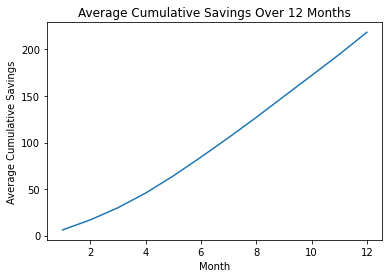

In [23]:
average_savings = [sum(customer_savings_ST[customer][month] for customer in customers) / len(customers) for month in range(12)]
plt.plot(months, average_savings)
plt.xlabel('Month')
plt.ylabel('Average Cumulative Savings')
plt.title('Average Cumulative Savings Over 12 Months')
plt.show()

# Partner Key Metrics with Tokenomics Strategy 1


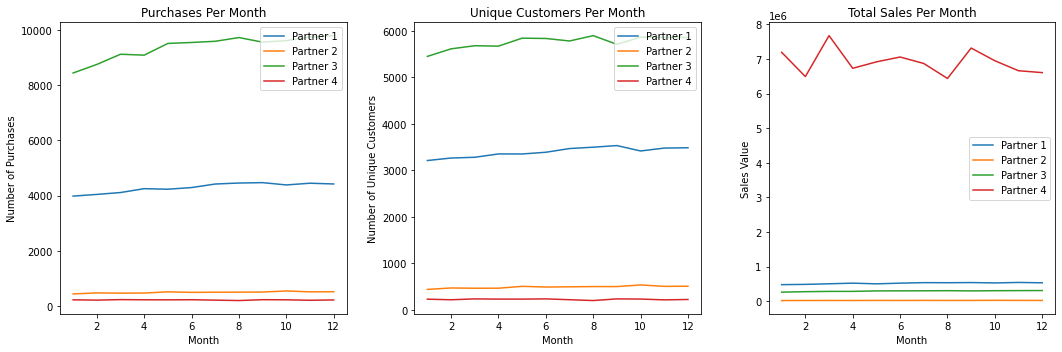

In [29]:
# Extracting metrics
months = list(range(1, 13))  # Representing months as numbers from 1 to 12

# Plot settings
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.5)

# Plotting Purchases Per Month for each partner
plt.subplot(1, 3, 1)
for partner in partner_metrics:
    plt.plot(months, partner_metrics[partner]["Purchases Per Month"], label=partner)
plt.title("Purchases Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.legend()

# Plotting Unique Customers Per Month for each partner
plt.subplot(1, 3, 2)
for partner in partner_metrics:
    plt.plot(months, partner_metrics[partner]["Unique Customers Per Month"], label=partner)
plt.title("Unique Customers Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Unique Customers")
plt.legend()

# Plotting Total Sales Per Month for each partner
plt.subplot(1, 3, 3)
for partner in partner_metrics:
    plt.plot(months, partner_metrics[partner]["Total Sales Per Month"], label=partner)
plt.title("Total Sales Per Month")
plt.xlabel("Month")
plt.ylabel("Sales Value")
plt.legend()

plt.tight_layout()
plt.show()

# The Baseline Model

{'Partner 1': {'Purchases Per Month': [3509, 3606, 3480, 3637, 3582, 3582, 3496, 3681, 3578, 3576, 3511, 3547], 'Unique Customers Per Month': [2915, 2992, 2893, 2993, 3003, 2952, 2903, 3040, 2983, 2986, 2946, 2951], 'Total Sales Per Month': [425282.617201879, 440626.95697332534, 418987.9489549462, 439353.0945995704, 434237.73677510605, 433716.0986902521, 422657.5431709175, 448546.42607998324, 440153.3711801113, 434713.2737008745, 425677.12111469556, 429278.00902620534], 'Average Basket Value Per Month': 121.02565802825073}, 'Partner 2': {'Purchases Per Month': [433, 430, 453, 417, 454, 420, 425, 453, 460, 463, 423, 427], 'Unique Customers Per Month': [427, 419, 445, 407, 443, 410, 415, 438, 450, 456, 414, 412], 'Total Sales Per Month': [21696.705400293748, 21587.12444188058, 23111.15498201156, 20692.991471812544, 21732.822479043156, 20468.564573644584, 20943.682627265633, 22724.253529786823, 23689.0450387947, 23493.816748850455, 20352.89768532091, 20762.67225598504], 'Average Basket Va

# Comparative Charts (Partner Key Metrics): Baseline vs. Tokenomics 1

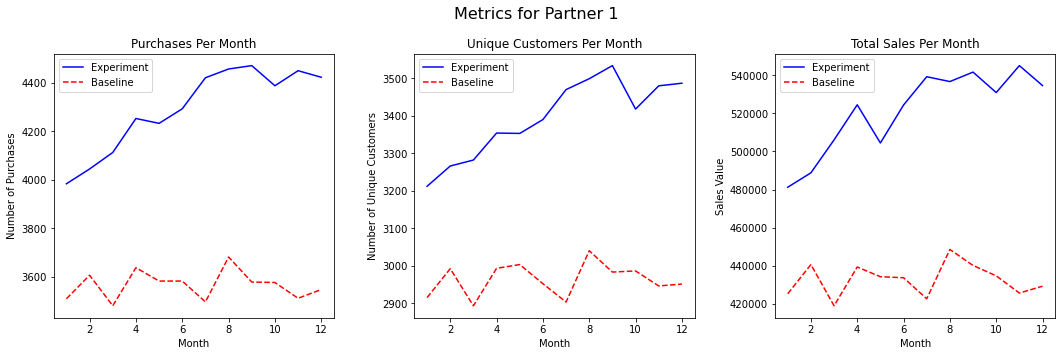

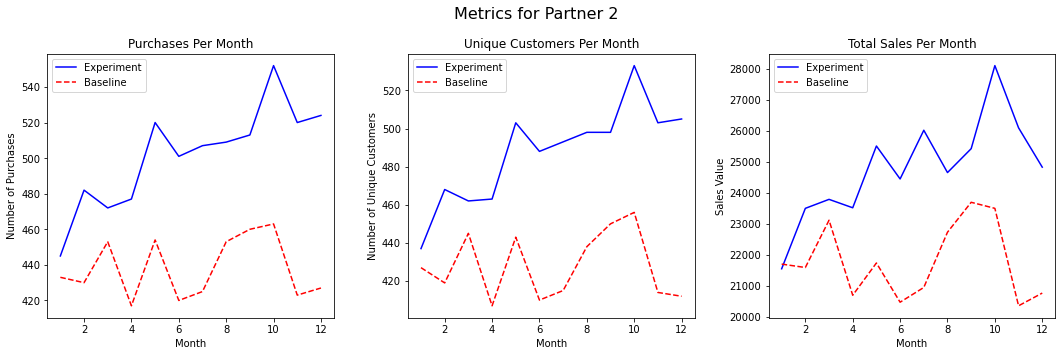

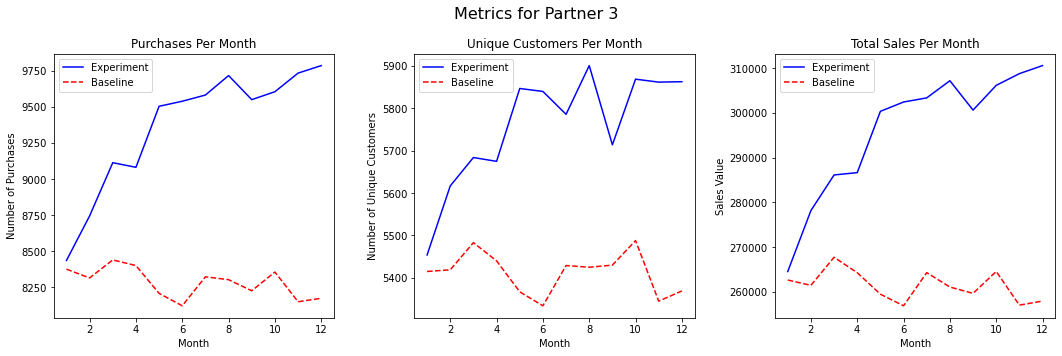

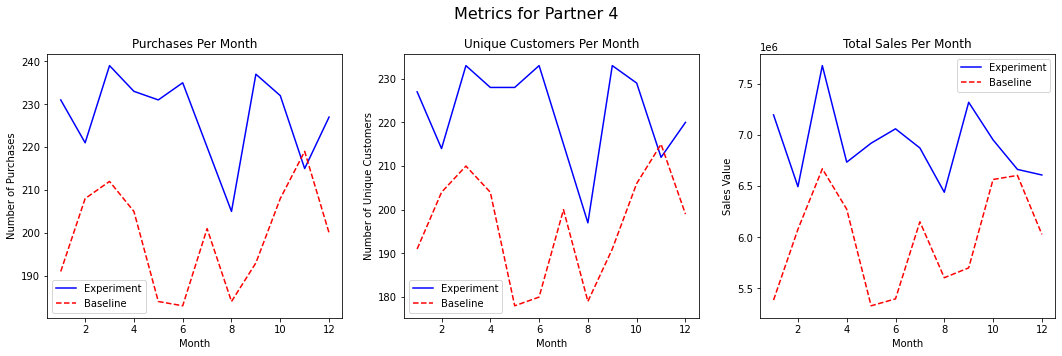

In [32]:
# Extracting metrics
months = list(range(1, 13))  # Representing months as numbers from 1 to 12

# For each partner, create a comparison plot
for partner in partner_metrics:

    # Plot settings
    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(f"Metrics for {partner}", fontsize=16)

    # Plotting Purchases Per Month comparison
    plt.subplot(1, 3, 1)
    plt.plot(months, partner_metrics[partner]["Purchases Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Purchases Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Purchases Per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Purchases")
    plt.legend()

    # Plotting Unique Customers Per Month comparison
    plt.subplot(1, 3, 2)
    plt.plot(months, partner_metrics[partner]["Unique Customers Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Unique Customers Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Unique Customers Per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Unique Customers")
    plt.legend()

    # Plotting Total Sales Per Month comparison
    plt.subplot(1, 3, 3)
    plt.plot(months, partner_metrics[partner]["Total Sales Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Total Sales Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Total Sales Per Month")
    plt.xlabel("Month")
    plt.ylabel("Sales Value")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title spacing
    plt.show()